<a href="https://colab.research.google.com/github/Nataliahfk/estadistica_python/blob/main/optimizaci%C3%B3n_vuelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Desarrollar un modelo que nos permita prever el atraso con el menor tiempo posible.Esto quiere decir, que si un vuelo se atrasa yo tengo un margen de tiempo dentro de ese periodo que me permitira poder establecer si este vuelo saldrá edentro del horario.

Esto ayuda a reducir costos y mantener una buena satisfaccion del cliente.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import yellowbrick

print(f'Versión de pandas: {pd.__version__}')
print(f'Versión de numpy: {np.__version__}')
print(f'Versión de scikit-learn (sklearn): {sklearn.__version__}')
print(f'Versión de seaborn: {sns.__version__}')
print(f'Versión de yellowbrick: {yellowbrick.__version__}')

Versión de pandas: 2.2.2
Versión de numpy: 2.0.2
Versión de scikit-learn (sklearn): 1.6.1
Versión de seaborn: 0.13.2
Versión de yellowbrick: 1.5


In [2]:
datos = pd.read_csv('/content/flights.csv')
datos

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0.0,2010.0,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0.0,2010.0,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0.0,2010.0,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0.0,2010.0,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0.0,2010.0,False,15.016271
...,...,...,...,...,...,...,...,...,...,...,...
51227,23,YE,Embraer E175,schengen,TCY,18.801235,21.801235,130.0,2019.0,False,6.928105
51228,18,BZ,Airbus A320,schengen,TZF,14.258911,20.258911,130.0,2019.0,False,0.695547
51229,17,BZ,Airbus A330,non-schengen,CNU,16.718722,21.718722,130.0,2019.0,False,-2.228246
51230,24,BZ,Airbus A320,schengen,FJB,9.668655,12.668655,130.0,2019.0,False,1.786890


In [3]:
datos.shape

(51232, 11)

In [4]:
# para calcular los segundos
round(.88*60)

53

In [5]:
round(.20*60)

12

Ejemplo de los horarios:

- hora de llegada: 8.885071	 // 8:53
- hora de salida: 10.885071	 // 10:53
- retraso : 70.205981    //  70 min con 20 segundos


In [6]:
datos = datos.rename(columns={
    'flight_id': 'ID_vuelo',
    'airline': 'Aerolínea',
    'aircraft_type': 'Tipo_aeronave',
    'schengen': 'Schengen',
    'origin': 'Origen',
    'arrival_time': 'Hora_llegada',
    'departure_time': 'Hora_salida',
    'day': 'Día',
    'year': 'Año',
    'is_holiday': 'Es_feriado',
    'delay': 'Retraso'
})

In [7]:
datos

,ID_vuelo,Aerolínea,Tipo_aeronave,Schengen,Origen,Hora_llegada,Hora_salida,Día,Año,Es_feriado,Retraso
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0.0,2010.0,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0.0,2010.0,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0.0,2010.0,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0.0,2010.0,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0.0,2010.0,False,15.016271
...,...,...,...,...,...,...,...,...,...,...,...
51227,23,YE,Embraer E175,schengen,TCY,18.801235,21.801235,130.0,2019.0,False,6.928105
51228,18,BZ,Airbus A320,schengen,TZF,14.258911,20.258911,130.0,2019.0,False,0.695547
51229,17,BZ,Airbus A330,non-schengen,CNU,16.718722,21.718722,130.0,2019.0,False,-2.228246
51230,24,BZ,Airbus A320,schengen,FJB,9.668655,12.668655,130.0,2019.0,False,1.786890


In [8]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51232 entries, 0 to 51231
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID_vuelo       51232 non-null  int64  
 1   Aerolínea      51232 non-null  object 
 2   Tipo_aeronave  51232 non-null  object 
 3   Schengen       51232 non-null  object 
 4   Origen         51232 non-null  object 
 5   Hora_llegada   51232 non-null  float64
 6   Hora_salida    51231 non-null  float64
 7   Día            51231 non-null  float64
 8   Año            51231 non-null  float64
 9   Es_feriado     51231 non-null  object 
 10  Retraso        51231 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 4.3+ MB


In [9]:
# Variables numericas
datos.describe()

,ID_vuelo,Hora_llegada,Hora_salida,Día,Año,Retraso
count,51232.000000,51232.000000,51231.000000,51231.000000,51231.000000,51231.000000
mean,15.452510,13.283942,16.481341,177.521520,2014.190900,12.571004
std,8.650382,4.027703,4.147593,106.008078,2.707459,23.166127
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-40.976659
25%,8.000000,8.939996,12.668655,85.000000,2012.000000,-4.477346
50%,15.000000,14.258911,16.376052,175.000000,2014.000000,9.795130
75%,23.000000,16.909690,20.041281,270.000000,2017.000000,27.690392
max,30.000000,19.341235,23.341235,364.000000,2019.000000,123.340562


en la columna retraso aparece:
- min con un valor -41.028033 eso significa que el vuelo salio con 41 minutos de adelanto.
- 25% el primer quartil, o el primer 25% salio con -4.412876 app 4 min 20 segundos adelantado
- La mediana 50% o segundo quantil tengo app 9.740454 un atraso de 9 min 45 seg
- el 75% tiene un retraso de 27.650853 eso es 27 min con 40 seg
- y el max son 125 min con 40 seg. que es + de 2 hrs.


Lo que genera perdidas, molestias de los pasajeros, etc.



In [10]:
# variables categoricas
datos.describe(include='object')

,Aerolínea,Tipo_aeronave,Schengen,Origen,Es_feriado
count,51232,51232,51232,51232,51231
unique,3,6,2,10,2
top,BZ,Airbus A320,schengen,TZF,False
freq,34222,22151,30678,10178,48486


- unique muestra que hay 3 aerolineas, 6 tipos de naves, 2 Schengen (sí, no) y 10 aeropuertos de origen
- top muestra que la aerolinea que mas se presenta en los datos es BZ, el tipo de avion es AirbusA320,  Schengen y el aeropuerto de origen es TZF.
- freq es la frecuencia del top.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
promedio_retraso = datos.groupby('Aerolínea')['Retraso'].mean().reset_index() # .reset_index() para no dejarlo como indice, sino como columna
promedio_retraso

,Aerolínea,Retraso
0,BZ,3.078038
1,MM,40.451053
2,YE,25.783654


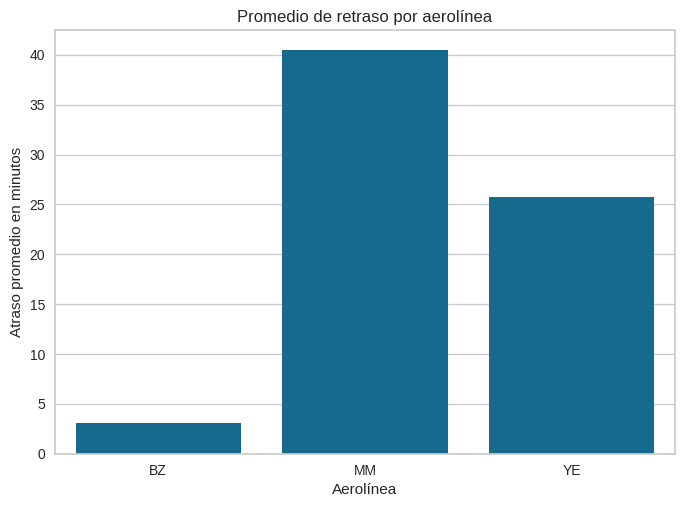

In [13]:
sns.barplot(x='Aerolínea', y='Retraso', data=promedio_retraso)
plt.title('Promedio de retraso por aerolínea')
plt.xlabel('Aerolínea')
plt.ylabel('Atraso promedio en minutos')
plt.show()

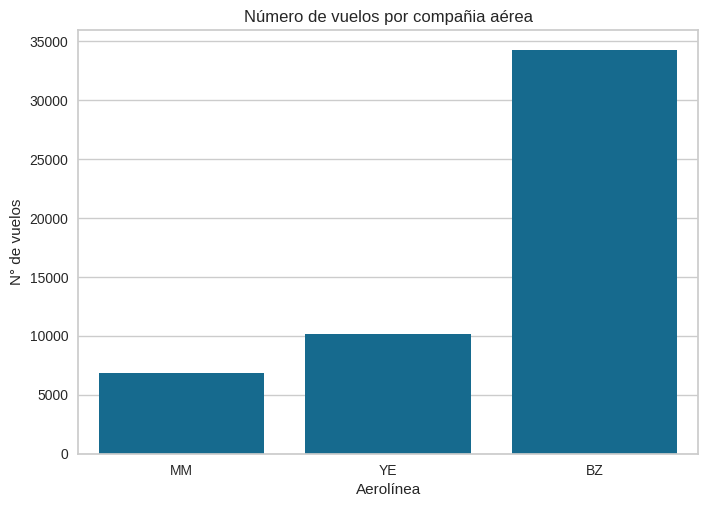

In [14]:
sns.countplot(x='Aerolínea', data=datos)
plt.title('Número de vuelos por compañia aérea')
plt.xlabel('Aerolínea')
plt.ylabel('N° de vuelos')
plt.show()

In [15]:
datos.columns

Index(['ID_vuelo', 'Aerolínea', 'Tipo_aeronave', 'Schengen', 'Origen',
       'Hora_llegada', 'Hora_salida', 'Día', 'Año', 'Es_feriado', 'Retraso'],
      dtype='object')

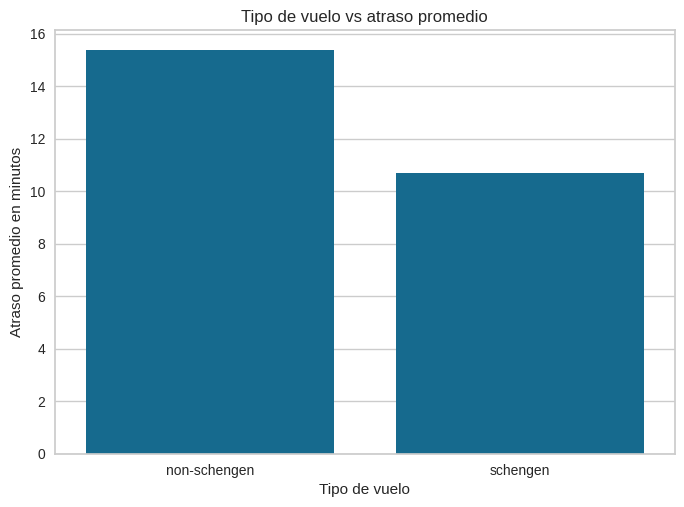

In [16]:
promedio_retraso = datos.groupby('Schengen')['Retraso'].mean().reset_index()
sns.barplot(x='Schengen', y='Retraso', data=promedio_retraso)
plt.title('Tipo de vuelo vs atraso promedio')
plt.xlabel('Tipo de vuelo')
plt.ylabel('Atraso promedio en minutos')
plt.show()

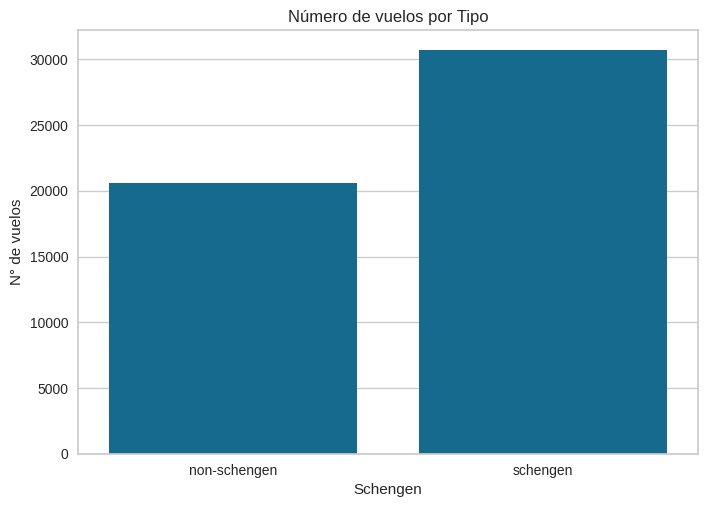

In [17]:
sns.countplot(x='Schengen', data=datos)
plt.title('Número de vuelos por Tipo')
plt.xlabel('Schengen')
plt.ylabel('N° de vuelos')
plt.show()

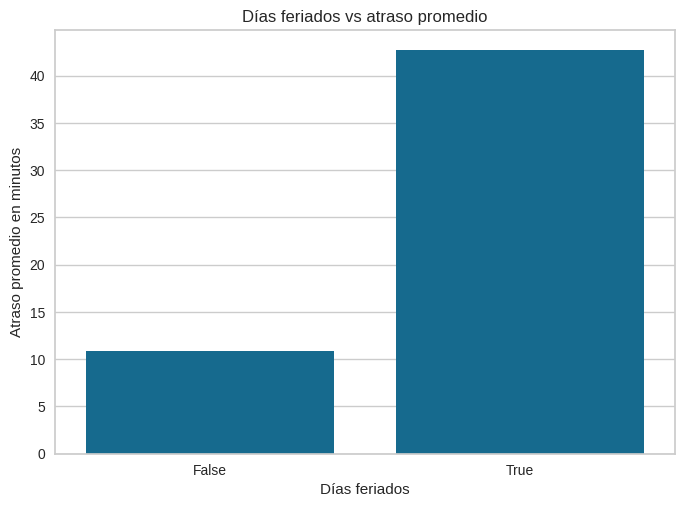

In [18]:
promedio_retraso = datos.groupby('Es_feriado')['Retraso'].mean().reset_index()
sns.barplot(x='Es_feriado', y='Retraso', data=promedio_retraso)
plt.title('Días feriados vs atraso promedio')
plt.xlabel('Días feriados')
plt.ylabel('Atraso promedio en minutos')
plt.show()

In [19]:
order = datos['Tipo_aeronave'].value_counts().index
order

Index(['Airbus A320', 'Airbus A330', 'Boeing 787', 'Embraer E175',
       'Boeing 737', 'Boeing 777'],
      dtype='object', name='Tipo_aeronave')

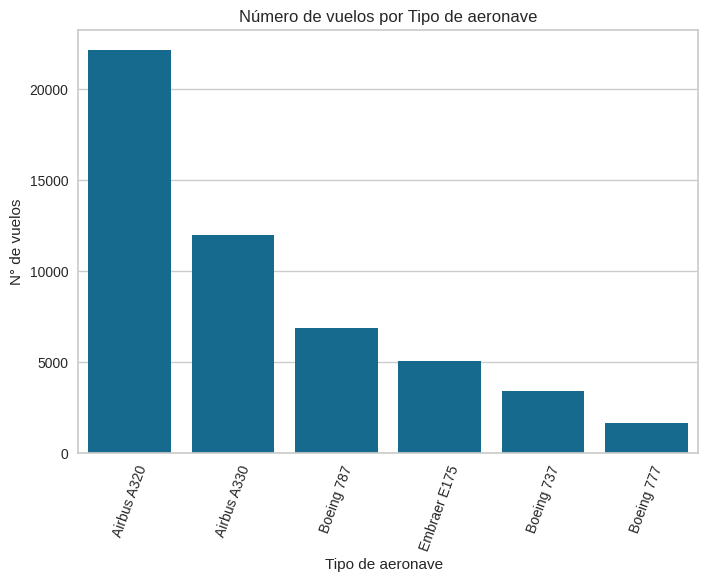

In [20]:
order = datos['Tipo_aeronave'].value_counts().index
sns.countplot(x='Tipo_aeronave', data=datos, order=order)
plt.title('Número de vuelos por Tipo de aeronave')
plt.xticks(rotation =70)
plt.xlabel('Tipo de aeronave  ')
plt.ylabel('N° de vuelos')
plt.show()

In [21]:
datos.columns

Index(['ID_vuelo', 'Aerolínea', 'Tipo_aeronave', 'Schengen', 'Origen',
       'Hora_llegada', 'Hora_salida', 'Día', 'Año', 'Es_feriado', 'Retraso'],
      dtype='object')

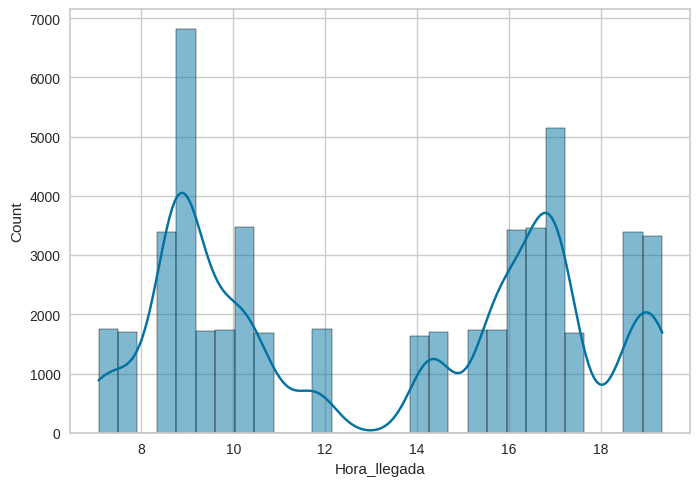

In [22]:
sns.histplot(data=datos,x='Hora_llegada',kde=True);

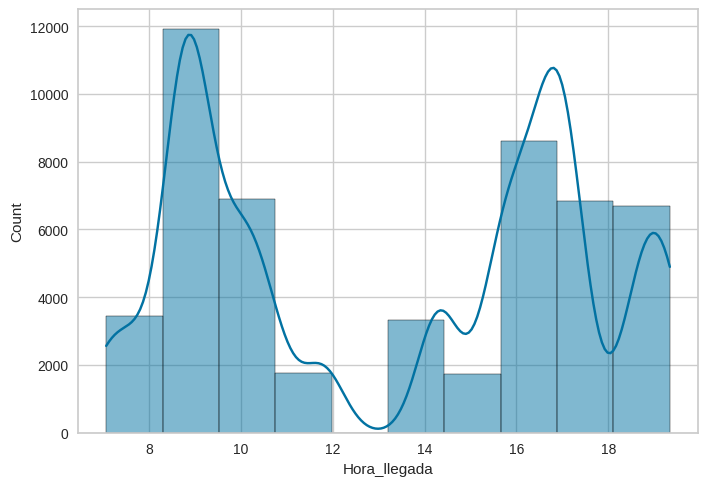

In [23]:
sns.histplot(data=datos,x='Hora_llegada',kde=True,bins=10);

In [24]:
import numpy as np

def ancho_bin(df, columna):
    x = df[columna].dropna()
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25  # rango intercuartílico
    n = len(x)
    bin_width = 2 * iqr / np.cbrt(n)  # fórmula de Freedman–Diaconis
    return bin_width

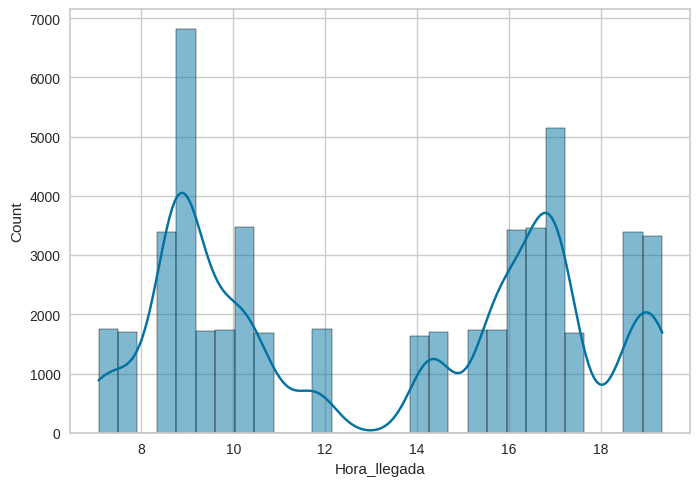

In [25]:
binwidth = ancho_bin(datos, 'Hora_llegada').item()

sns.histplot(
    data=datos,
    x='Hora_llegada',
    kde=True,
    binwidth=binwidth  # ✅ corregido
);


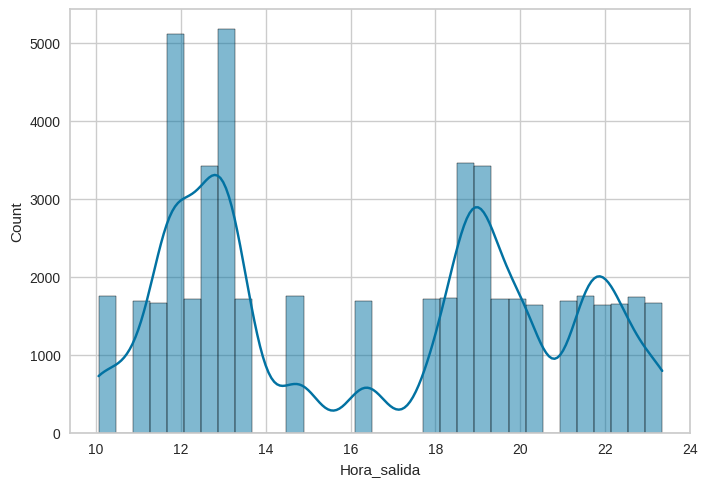

In [26]:
binwidth = ancho_bin(datos, 'Hora_salida').item()

sns.histplot(
    data=datos,
    x='Hora_salida',
    kde=True,
    binwidth=binwidth  # ✅ corregido
);


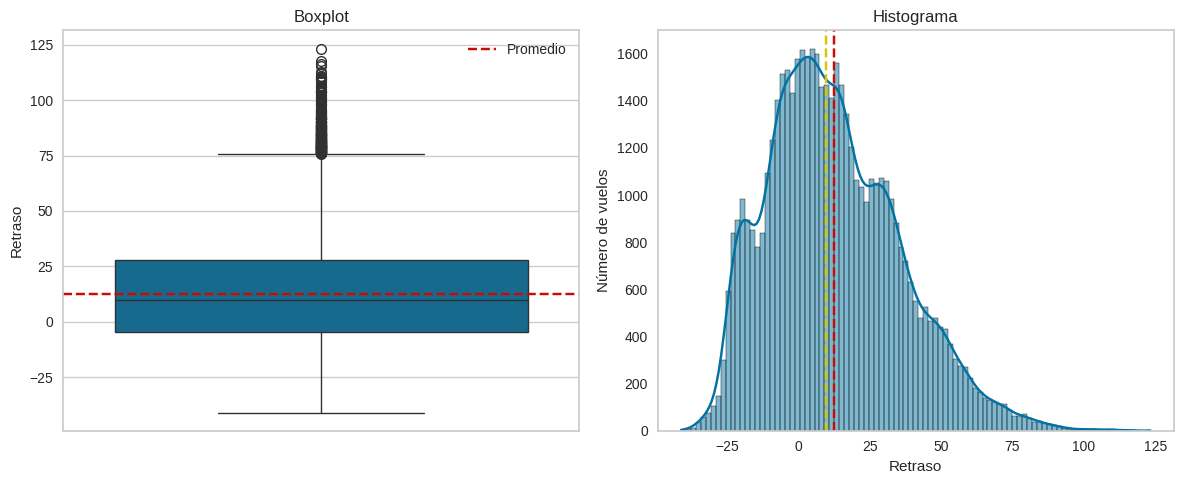

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Promedio y mediana
atraso_prom = datos['Retraso'].mean()
atraso_med = datos['Retraso'].median()

# Crear figura con 1 fila y 2 columnas
fig, ax = plt.subplots(1, 2, figsize=(12,5))  # ⚠ plt.subplots, no subplot

# Boxplot a la izquierda
sns.boxplot(data=datos, y='Retraso', ax=ax[0])
ax[0].set_title('Boxplot')
ax[0].axhline(y=atraso_prom, color='r', linestyle='--', label='Promedio')
ax[0].legend()

binwidth = ancho_bin(datos, 'Retraso')

sns.histplot(data=datos, x='Retraso', kde=True, binwidth=binwidth, ax=ax[1])
plt.ylabel('Número de vuelos')
plt.grid(False)
ax[1].set_title('Histograma')
ax[1].axvline(x=atraso_prom, color='r', linestyle='--', label='Promedio')
ax[1].axvline(x=atraso_med, color='y', linestyle='--', label='Mediana')

plt.tight_layout()
plt.show()

El feature engineering es un concepto fundamental en el campo de la ciencia de datos y el aprendizaje automático, y desempeña un papel crucial en el proceso de desarrollo de modelos predictivos y analíticos. Esta técnica implica la creación, transformación y selección de variables, también conocidas como "features", a partir de los datos brutos disponibles, con el fin de mejorar el rendimiento de los modelos. Pero, ¿qué serían features?

¿Qué son las features?
Las features son las variables o atributos que un modelo de machine learning utiliza para hacer predicciones o clasificaciones. Representan la información que el modelo tiene a su disposición para aprender patrones en los datos. Por ejemplo, si estamos construyendo un modelo para predecir el precio de una casa, las features pueden incluir el número de habitaciones, la superficie en metros cuadrados, la ubicación geográfica, la proximidad a escuelas, entre otras.

La importancia del Feature Engineering:
Mejora el rendimiento del modelo: Elegir las features correctas y transformarlas adecuadamente puede resultar en modelos más precisos y eficientes. Features bien diseñadas pueden capturar información relevante y eliminar ruido en los datos.
Reduce la dimensionalidad: En conjuntos de datos con muchas features, la dimensionalidad de los datos puede convertirse en un problema. El feature engineering puede ayudar a reducir la cantidad de features, manteniendo solo aquellas que son realmente informativas para el modelo.
Técnicas de Feature Engineering:
Existen varias técnicas de feature engineering, incluyendo:

Creación de features: Esto implica la creación de nuevas features basadas en las existentes. Por ejemplo, combinar las features de superficie y valor de una propiedad para crear una feature que represente el valor por metro cuadrado de esa propiedad. O, si tienes datos de fecha y hora, puedes crear una nueva característica que represente el día de la semana. Esto puede ser útil porque tal vez haya patrones que ocurren en días específicos de la semana.
Transformación de features: Se pueden aplicar funciones matemáticas a las features existentes para hacerlas más adecuadas para el modelo. Ejemplos incluyen aplicar logaritmos o escalar valores para reducir la escala en la que se encuentra la variable.
Selección de features: No todas las features son igualmente importantes. La selección de features implica identificar y mantener solo las más relevantes para el problema en cuestión.

Durante el video, se presentaron algunas de las métricas más comunes para evaluar modelos de regresión, como RMSE, MAE y R2. Junto con estas métricas, existen diversas otras que pueden ser bastante útiles durante la evaluación de un modelo de regresión. A continuación, podrás encontrar algunas de las métricas más utilizadas y sus traducciones en español:

Mean squared error - MSE (Error Cuadrático Medio);
Mean absolute error - MAE (Error Absoluto Medio);
Root Mean Squared Error - RMSE (Raíz Cuadrada del Error Cuadrático Medio);
Mean Squared Logarithmic Error - MSLE (Error Logarítmico Cuadrático Medio); y
Mean Absolute Percentage Error - MAPE (Porcentaje del Error Absoluto Medio).
Mean squared error - MSE
El Mean Squared Error (MSE), o Error Cuadrático Medio, es una métrica ampliamente utilizada para evaluar el rendimiento de un modelo de aprendizaje automático. Esta métrica calcula la media de los errores cuadrados, donde cada error es la diferencia entre el valor previsto por el modelo y el valor real. La elevación al cuadrado da mayor peso a los errores mayores, lo que puede ser útil cuando esos errores son particularmente indeseables. El MSE se define matemáticamente como:

En esta fórmula, "n" representa el número de observaciones o muestras, "y_i" es el valor real de la i-ésima observación y "ŷ_i" es el valor predicho para la i-ésima observación. El MSE se calcula tomando la diferencia entre los valores reales y los valores predichos, elevando al cuadrado, sumando todas estas diferencias al cuadrado y, a continuación, dividiendo por el número de observaciones "n".

Para evaluar la calidad de un modelo usando el MSE, cuanto más cerca de 0 esté el valor del MSE, mejor estará el modelo en predecir los valores deseados. Esto se debe a que un MSE de 0 indica que no hay diferencia entre los valores previstos y los valores reales, es decir, el modelo está haciendo predicciones perfectas.

Aunque el MSE es una métrica útil, vale la pena mencionar que tiene la desventaja de dar más peso a los outliers debido al cuadrado de cada término. Esto puede ser indeseable en muchos casos, llevando a los investigadores a usar alternativas, como el error absoluto medio (MAE).

La documentación de scikit-learn tiene información que ofrece más detalles sobre esta métrica en “mean_squared_error”.

Mean absolute error - MAE
El Error Absoluto Medio (MAE) es una medida de error común utilizada en modelos de regresión. Se calcula tomando la media de los valores absolutos de los errores. En otras palabras, para cada punto de datos, primero calculamos el error (la diferencia entre el valor predicho y el valor real), tomamos el valor absoluto de ese error (para asegurar que todos los errores sean positivos), y luego calculamos la media de todos estos errores absolutos. El MAE se define como:

En esta ecuación, "n" representa el número de observaciones o muestras, "y_i" es el valor real de la i-ésima observación y "ŷ_i" es el valor predicho para la i-ésima observación. El MAE se calcula tomando la diferencia absoluta entre los valores reales y los valores predichos para todas las observaciones, sumando estas diferencias absolutas y, a continuación, dividiendo por el número de observaciones "n".

El MAE es similar a la Métrica del Error Cuadrático Medio (MSE), pero en lugar de elevar los errores al cuadrado, simplemente toma el valor absoluto de los errores. Esto hace que el MAE sea menos sensible a outliers que el MSE, ya que los errores grandes no se amplifican por el cuadrado.

Al evaluar modelos de regresión con el MAE, un valor menor indica un modelo más preciso. En otras palabras, cuanto menor sea el MAE, mejor será el modelo en predecir el valor correcto para nuevos datos. El MAE tiene un límite inferior de 0, que indica un modelo perfecto (es decir, todas las predicciones son exactas).

Cabe destacar que, aunque el MAE es una métrica útil, no debe ser la única métrica utilizada para evaluar el rendimiento de un modelo de regresión. Otras métricas, como el MSE, la Raíz Cuadrada del Error Cuadrático Medio (RMSE) y el Coeficiente de Determinación (R2), también deben ser consideradas para obtener una evaluación completa de la capacidad de un modelo para hacer predicciones precisas.

La documentación de scikit-learn ofrece más detalles sobre esta métrica en “MAE”.

Root Mean Squared Error - RMSE
La Raíz Cuadrada del Error Cuadrático Medio (RMSE) es una métrica de evaluación comúnmente utilizada en modelos de regresión, que es esencialmente la raíz cuadrada del MSE (Error Cuadrático Medio). El RMSE se calcula tomando la raíz cuadrada de la media de los errores cuadrados, que son las diferencias entre los valores previstos y los valores reales, elevadas al cuadrado. Matemáticamente, el RMSE se define como:

Donde:

n es el número de muestras;
Ŷ_j es la predicción del modelo para la muestra j;
Y_j es el valor real para la muestra j.
El RMSE es una medida de la dispersión de los residuos (errores de predicción) y, al igual que el MSE, penaliza los errores mayores de forma más severa que los errores menores, debido al hecho de elevar al cuadrado las diferencias. Esto lo hace particularmente sensible a grandes errores.

Un valor menor de RMSE indica un mejor ajuste del modelo a los datos, es decir, las predicciones del modelo están más cerca de los valores reales. Es importante resaltar que, aunque el RMSE es una métrica útil, no debe ser la única métrica considerada al evaluar la calidad de un modelo de regresión.

Puedes acceder a la documentación de scikit-learn para saber más sobre esta métrica: metrics.mean_squared_error.

Mean Squared Logarithmic Error - MSLE
El Error Logarítmico Cuadrático Medio es una métrica de evaluación utilizada en problemas de predicción donde la escala de los valores objetivo o de las predicciones varía significativamente y los errores relativos son más importantes que los errores absolutos. El MSLE mide el error cuadrático medio entre los logaritmos naturales de los valores reales y los logaritmos naturales de las predicciones. Matemáticamente, se puede definir el MSLE de la siguiente manera:

Donde "n" representa el número de observaciones o muestras, "y_i" es el valor real de la i-ésima observación y "ŷ_i" es el valor predicho para la i-ésima observación. El MSLE se calcula tomando el logaritmo natural de los valores reales y predichos sumados a 1, calculando la diferencia entre estos logaritmos, elevando al cuadrado, sumando todas estas diferencias al cuadrado y, a continuación, dividiendo por el número de observaciones "n".

El principal punto de enfoque de esta métrica es medir la diferencia relativa entre los valores esperados y los predichos por el modelo, es decir, verifica la diferencia porcentual entre ellos. De modo que, pequeñas diferencias entre valores pequeños son tratadas igualmente a grandes diferencias entre valores grandes, a diferencia de lo que ocurre en el MSE, como se muestra en el siguiente ejemplo:

Esto nos muestra que las grandes diferencias entre los valores reales y predichos tienen poca variación en el resultado final de la métrica. Por lo tanto, esta métrica se utiliza más cuando no deseamos que grandes errores sean significativamente más penalizados que errores pequeños.

Para saber más sobre esta métrica y cómo utilizarla, puedes acceder a la documentación de scikit-learn: metrics.mean_squared_log_error.

Mean Absolute Percentage Error - MAPE
El Mean Absolute Percentage Error es muy similar al Mean Absolute Error - MAE, con la diferencia de que mide la precisión como un porcentaje y puede ser calculado como el porcentaje del MAE para cada muestra. El MAPE se utiliza mucho en problemas de regresión, ya que proporciona una interpretación bastante intuitiva sobre el error relativo. La definición del MAPE es:

Donde "n" representa el número de observaciones o muestras, "y_i" es el valor real de la i-ésima observación, "ŷ_i" es el valor predicho para la i-ésima observación, y el MAPE se calcula como la media de los porcentajes absolutos de las diferencias entre los valores reales y los valores predichos en relación con los valores reales. El resultado se multiplica por 100% para expresar el error como un porcentaje.

El MAPE se utiliza frecuentemente como una métrica de error para evaluar la precisión de las predicciones en problemas de predicción y se expresa como un porcentaje del error medio absoluto en relación con los valores reales. Para saber más sobre esta métrica y cómo utilizarla, puedes acceder a la documentación de scikit-learn: metrics.mean_absolute_percentage_error.

Al usar GridSearchCV para optimizar hiperparámetros, es fundamental entender cuántas veces se entrena y evalúa el algoritmo para determinar la complejidad computacional y el tiempo necesario para la búsqueda de hiperparámetros. En el código a continuación, analiza cuántas veces se entrena y evalúa el algoritmo:

El RandomForestRegressor es un modelo de conjunto que combina varios árboles de decisión para hacer predicciones más robustas y precisas a través de la técnica de Bagging.

Los hiperparámetros son configuraciones que puedes ajustar para controlar el comportamiento del RandomForestRegressor. A continuación, se presenta una lista de los principales hiperparámetros:

1 - n_estimators:

Este hiperparámetro especifica el número de árboles de decisión que se crearán en el bosque aleatorio. Cuanto mayor sea el número de estimadores, mayor será la capacidad del modelo para ajustarse a los datos. Sin embargo, un número muy alto puede llevar a un aumento en el tiempo de entrenamiento.
2 - criterion:

El hiperparámetro criterion determina la función de medición de la calidad de una división durante la construcción de los árboles. Para regresión, el valor predeterminado es "mse" (Error Cuadrático Medio), que calcula la media de los cuadrados de los errores. Otra opción es "mae" (Error Absoluto Medio), que utiliza la media de los valores absolutos de los errores.
3 - max_depth:

Este hiperparámetro controla la profundidad máxima de los árboles de decisión en el bosque. Limitar la profundidad puede ayudar a evitar el sobreajuste, ya que impide que los árboles se ajusten demasiado a los datos de entrenamiento y no puedan hacer buenas predicciones para nuevos datos.
4 - min_samples_split:

El min_samples_split determina el número mínimo de muestras necesarias para dividir un nodo interno del árbol. Esto ayuda a controlar el crecimiento de los árboles y evita divisiones que llevan a nodos con pocas muestras.
5 - min_samples_leaf:

Este hiperparámetro define el número mínimo de muestras requeridas en una hoja (nodo terminal) del árbol. Esto ayuda a controlar la granularidad del árbol y puede impedir que las hojas contengan muy pocas muestras.
6 - max_features:

max_features especifica el número máximo de características a considerar al buscar la mejor división en cada nodo. Los valores comunes incluyen "auto" (sqrt(n_features)), "sqrt" (también sqrt(n_features)), "log2" (log2(n_features)), o un número entero que representa la cantidad exacta de características a considerar.
7 - random_state:

Este hiperparámetro define una semilla para el generador de números aleatorios utilizado para crear el bosque aleatorio. Definir un valor fijo para random_state garantiza que el modelo sea reproducible.
8 - n_jobs:

n_jobs especifica el número de núcleos de CPU a utilizar para el entrenamiento en paralelo. Si se define como -1, se utilizarán todos los núcleos disponibles.
Estos son algunos de los principales hiperparámetros del RandomForestRegressor en scikit-learn. La elección adecuada de estos hiperparámetros puede afectar significativamente el rendimiento y la capacidad de generalización del modelo para tareas de regresión. Para consultar los otros hiperparámetros faltantes, puedes consultar la documentación oficial de scikit-learn.